<a name="software-requirements"></a>
# Software Requirements

In [ ]:
%%bash
python -m pip install --upgrade pip
pip install git+https://github.com/ProfessorGuineapig/climate-learn.git

In [2]:
#After installing "rich", it is necessary to restart your runtime in order to ensure that all of the necessary components are properly loaded and running. 
!pip install -U rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.3
    Uninstalling rich-13.3.3:
      Successfully uninstalled rich-13.3.3


In [7]:
!pip install lion-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from climate_learn.utils.data import load_dataset, view
from climate_learn.data import download1

dataset = load_dataset("/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.20/2m_temperature")
view(dataset)

<xarray.Dataset>
Dimensions:    (longitude: 16, latitude: 16, time: 291542)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.8 -80.6 -80.4 ... -78.4 -78.2 -78.0
  * latitude   (latitude) float32 45.0 44.8 44.6 44.4 ... 42.6 42.4 42.2 42.0
  * time       (time) datetime64[ns] 1990-01-01 ... 2023-04-05T13:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 16, 16), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-10 08:34:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

<a name="spatial-downscaling"></a>
# Spatial Downscaling

## Data Preparation

In [9]:
from climate_learn.utils.datetime import Year, Days, Hours
from climate_learn.data.climate_dataset.args import ERA5Args
from climate_learn.data.tasks.args import DownscalingArgs
from climate_learn.data import download, DataModuleArgs, DataModule


lowres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.20/",
    variables = ["2m_temperature"],
    years = range(2015, 2022),
)

highres_data_args = ERA5Args(
    root_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/data/copernicus/era5/0.05/",
    variables = ["2m_temperature"],
    years = range(2015, 2022),
)

downscaling_args = DownscalingArgs(
    dataset_args=lowres_data_args,
    highres_dataset_args = highres_data_args,
    in_vars = ["2m_temperature"],
    out_vars = ["2m_temperature"],
    subsample = 6,
)

data_module_args = DataModuleArgs(
    task_args = downscaling_args,
    train_start_year = 2015,
    val_start_year = 2018,
    test_start_year = 2020,
    end_year = 2022,
)

data_module = DataModule(
    data_module_args = data_module_args,
    batch_size = 32,
    num_workers = 1
)

Creating train dataset


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Creating val dataset


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Creating test dataset


100%|██████████| 3/3 [00:02<00:00,  1.06it/s]


## Model initialization

In [10]:
from climate_learn.models import load_model
from lion_pytorch import Lion
#from torch.optim import AdamW

model_kwargs = {
    "in_channels": len(data_module.hparams.data_module_args.train_task_args.in_vars),
    "out_channels": len(data_module.hparams.data_module_args.train_task_args.out_vars),
    "n_blocks": 4,
}

optim_kwargs = {
    "optimizer": Lion,
    "lr": 3.333e-5,
    "weight_decay": 1e-5,
    "warmup_epochs": 1,
    "max_epochs": 5,
}

model_module_downscaling = load_model(name = "resnet", task = "downscaling", model_kwargs = model_kwargs, optim_kwargs = optim_kwargs)

In [11]:
# latitude long info, 
from climate_learn.models import set_climatology
set_climatology(model_module_downscaling, data_module)

In [12]:
import os
import torch
from torchvision.transforms import Normalize

#Continued by following the previous training session
save_dir = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#Continued by following the previous training session
save_path = "/content/drive/MyDrive/Climate/.climate_tutorial/trained model/trained_model_Toronto_04_10_downscaling_Res.pth"

# Load the state_dict and denormalization layer information
checkpoint = torch.load(save_path)
model_state_dict = checkpoint['model_state_dict']
denormalization_mean = checkpoint['denormalization_mean']
denormalization_std = checkpoint['denormalization_std']
pred_range = checkpoint['pred_range']
lat = checkpoint['lat']
test_clim = checkpoint['test_clim']
train_clim = checkpoint['train_clim']

# Update the model_module_downscaling with the loaded state_dict
model_module_downscaling.load_state_dict(model_state_dict)
model_module_downscaling.pred_range = pred_range
model_module_downscaling.lat = lat
model_module_downscaling.test_clim = test_clim
model_module_downscaling.train_clim = train_clim

# Recreate the denormalization layer using the saved mean and standard deviation
model_module_downscaling.denormalization = Normalize(mean=denormalization_mean, std=denormalization_std)

In [ ]:
model_module_downscaling

## Evaluation 


In [14]:
from climate_learn.training import Trainer

trainer = Trainer(
    seed = 0,
    accelerator = "gpu",
    precision = 16,
    max_epochs = 5,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.9/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(


In [15]:
trainer.test(model_module_downscaling, data_module)

Creating train dataset


100%|██████████| 3/3 [00:00<00:00, 30.93it/s]


Creating val dataset


100%|██████████| 2/2 [00:00<00:00, 41.56it/s]


Creating test dataset


100%|██████████| 3/3 [00:00<00:00, 39.94it/s]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/mean_bias         │      -0.4124308228492737      │
│ test/mean_bias_2m_temperature │      -0.4124308228492737      │
│         test/pearson          │      0.9967161095043267       │
│ test/pearsonr_2m_temperature  │      0.9967161095043267       │
│           test/rmse           │       0.523897647857666       │
│   test/rmse_2m_temperature    │       0.523897647857666       │
└───────────────────────────────┴───────────────────────────────┘

This visualization displays the results of a random test for the Resnet model. It shows the weather forecast for the spatial downscaling of the selected region (area = [42.0, -81.0, 45.0, -78.0]) in a short time period (1 days). The initial condition is the temperature of the date we selected to test, the ground truth is the actual temperature after 1 days, and the prediction is the outcome of the trained model. 

The mean square error of the Resnet model is relatively high, but its small size of less than 5MB makes it easy to deploy. This is a major advantage of the Resnet model, as it can be used in a variety of applications without taking up too much space.

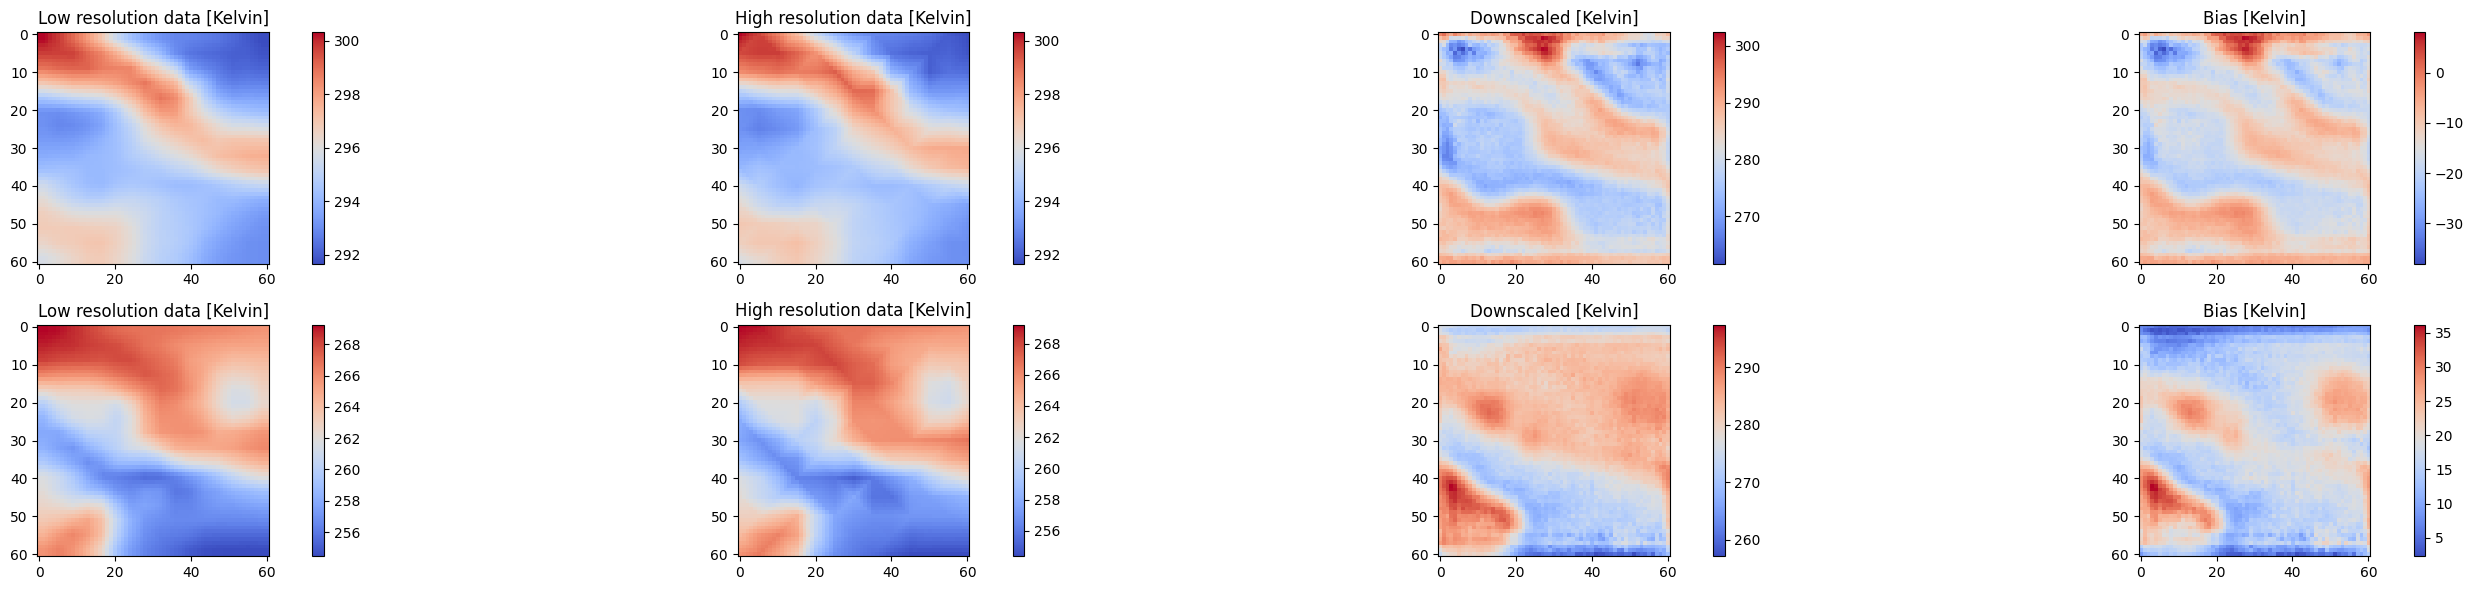

In [20]:
from climate_learn.utils import visualize

# if samples = 2, we randomly pick 2 initial conditions in the test set
visualize(model_module_downscaling, data_module, samples = 2)

# Deployment


In [ ]:
pip install gradio


In [22]:
#The modified visulization functions for deployment.
import matplotlib.pyplot as plt
from climate_learn.data.tasks import Downscaling, Forecasting


def interpolate_input(x: torch.Tensor, y: torch.Tensor):
    # interpolate input to match output size
    out_h, out_w = y.shape[-2], y.shape[-1]
    x = torch.nn.functional.interpolate(x, (out_h, out_w), mode="bilinear")
    return x

def visualize_gr(model_module, data_module, split="test", samples=2, save_dir=None, output=None):
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    task_dataset = eval(f"data_module.{split}_dataset")

    if type(samples) == int:
        idxs = random.sample(range(0, len(task_dataset)), samples)
    elif type(samples) == list:
        idxs = [
            np.searchsorted(
                task_dataset.time, np.datetime64(datetime.strptime(dt, "%Y-%m-%d:%H"))
            )
            for dt in samples
        ]
    else:
        raise Exception(
            "Invalid type for samples; Allowed int or list[datetime.datetime or np.datetime64]"
        )

    fig, axes = plt.subplots(len(idxs), 4, figsize=(60, 6 * len(idxs)), squeeze=False)

    for index, idx in enumerate(idxs):
        x, y, _, _ = task_dataset[idx]
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        x = interpolate_input(x, y)
        pred = model_module.forward(x.unsqueeze(0))

        inv_normalize = model_module.denormalization
        init_condition, gt = inv_normalize(x), inv_normalize(y)
        init_condition = np.flip(init_condition.detach().cpu().squeeze().numpy(), 0)
        pred = inv_normalize(pred)
        pred = np.flip(pred.detach().cpu().squeeze().numpy(), 0)
        gt = np.flip(gt.detach().cpu().squeeze().numpy(), 0)
        bias = pred - gt

        for i, np_array in enumerate([init_condition, gt, pred, bias]):
            ax = axes[index][i]
            im = ax.imshow(np_array)
            im.set_cmap(cmap=plt.cm.coolwarm)
            fig.colorbar(im, ax=ax)

        if isinstance(task_dataset, Forecasting):
            axes[index][0].set_title("Initial condition [Kelvin]")
            axes[index][1].set_title("Ground truth [Kelvin]")
            axes[index][2].set_title("Prediction [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        elif isinstance(task_dataset, Downscaling):
            axes[index][0].set_title("Low resolution data [Kelvin]")
            axes[index][1].set_title("High resolution data [Kelvin]")
            axes[index][2].set_title("Downscaled [Kelvin]")
            axes[index][3].set_title("Bias [Kelvin]")
        else:
            raise NotImplementedError

    fig.tight_layout()

    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "visualize.png"), dpi=300)
    elif output is not None:
        plt.savefig(output, format='png')
    else:
        plt.show()

In [ ]:
"""data_module.test_start_year = data_module_args.test_start_year
data_module.end_year = data_module_args.end_year"""

In [25]:
import gradio as gr
import numpy as np
from PIL import Image
from climate_learn.utils import visualize
import matplotlib.pyplot as plt
from climate_learn.data.tasks import Downscaling, Forecasting
from io import BytesIO
from datetime import datetime
import random
import numpy as np

data_module.test_start_year = data_module_args.test_start_year
data_module.end_year = data_module_args.end_year

def get_random_dates(data_module, n=2):
    test_start_year = data_module.test_start_year
    end_year = data_module.end_year

    random_dates = []
    for _ in range(n):
        random_year = random.randint(test_start_year, end_year - 1)
        random_month = random.randint(1, 12)
        random_day = random.randint(1, 28)
        random_hour = random.randint(0, 23)
        random_date = datetime(random_year, random_month, random_day, random_hour)
        random_dates.append(random_date.strftime("%Y-%m-%d:%H"))

    return ",".join(random_dates)

def visualize_gradio(dates: str):
    dates_list = dates.split(',')
    buffer = BytesIO()
    visualize_gr(model_module_downscaling, data_module, samples=dates_list, output=buffer)
    buffer.seek(0)
    img_binary = buffer.getvalue()
    img = Image.open(BytesIO(img_binary))
    return img

In [26]:
random_dates = get_random_dates(data_module)


layout = {
    "width": "100%",
    "height": "800px",
    "fullscreen": False,
    "title": "Climate Model Visualization",
    "description": "Randomly pick initial conditions in the test set and visualize the model's output.",
    "inputs": [
        ["Dates (YYYY-MM-DD:HH)", "text"],
    ],
    "outputs": [
        ["Output Image", "numpy_image"],
    ],
    "style": "vertical",
}

demo = gr.Interface(
    fn=visualize_gradio,
    inputs=gr.inputs.Textbox(lines=2, label="Dates (YYYY-MM-DD:HH)", default=random_dates),
    outputs=gr.outputs.Image('numpy'),
    layout=layout,
    title="Climate Model Visualization",
    description="Randomly pick initial conditions in the test set and visualize the model's output.",
    split="none",
)

demo.launch()

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:43: UserWarning: You ha

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Testing with dates: 2021-03-25:03,2021-09-23:19


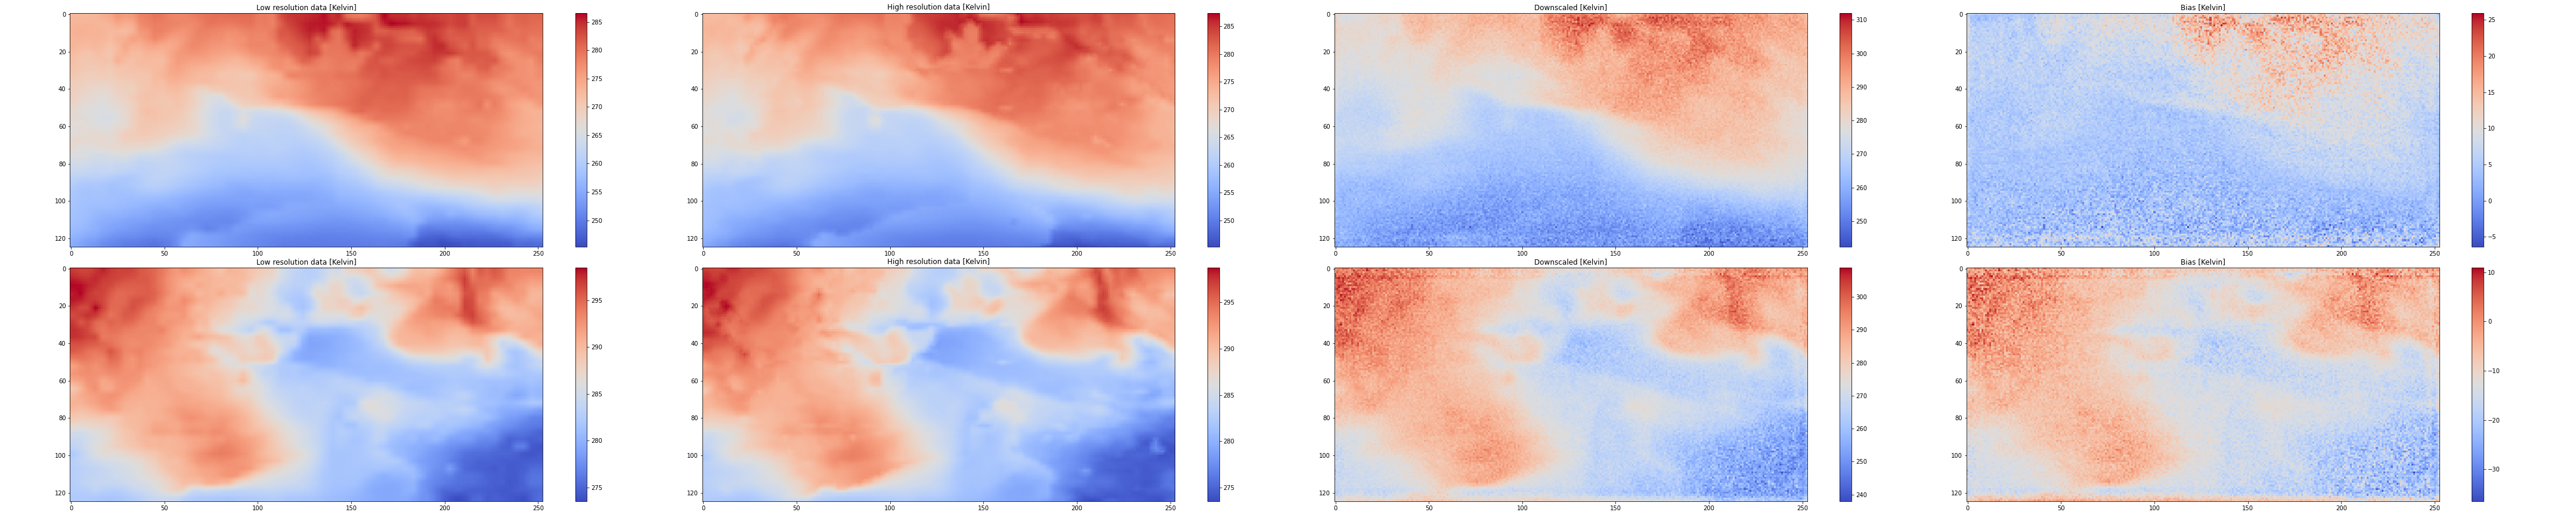

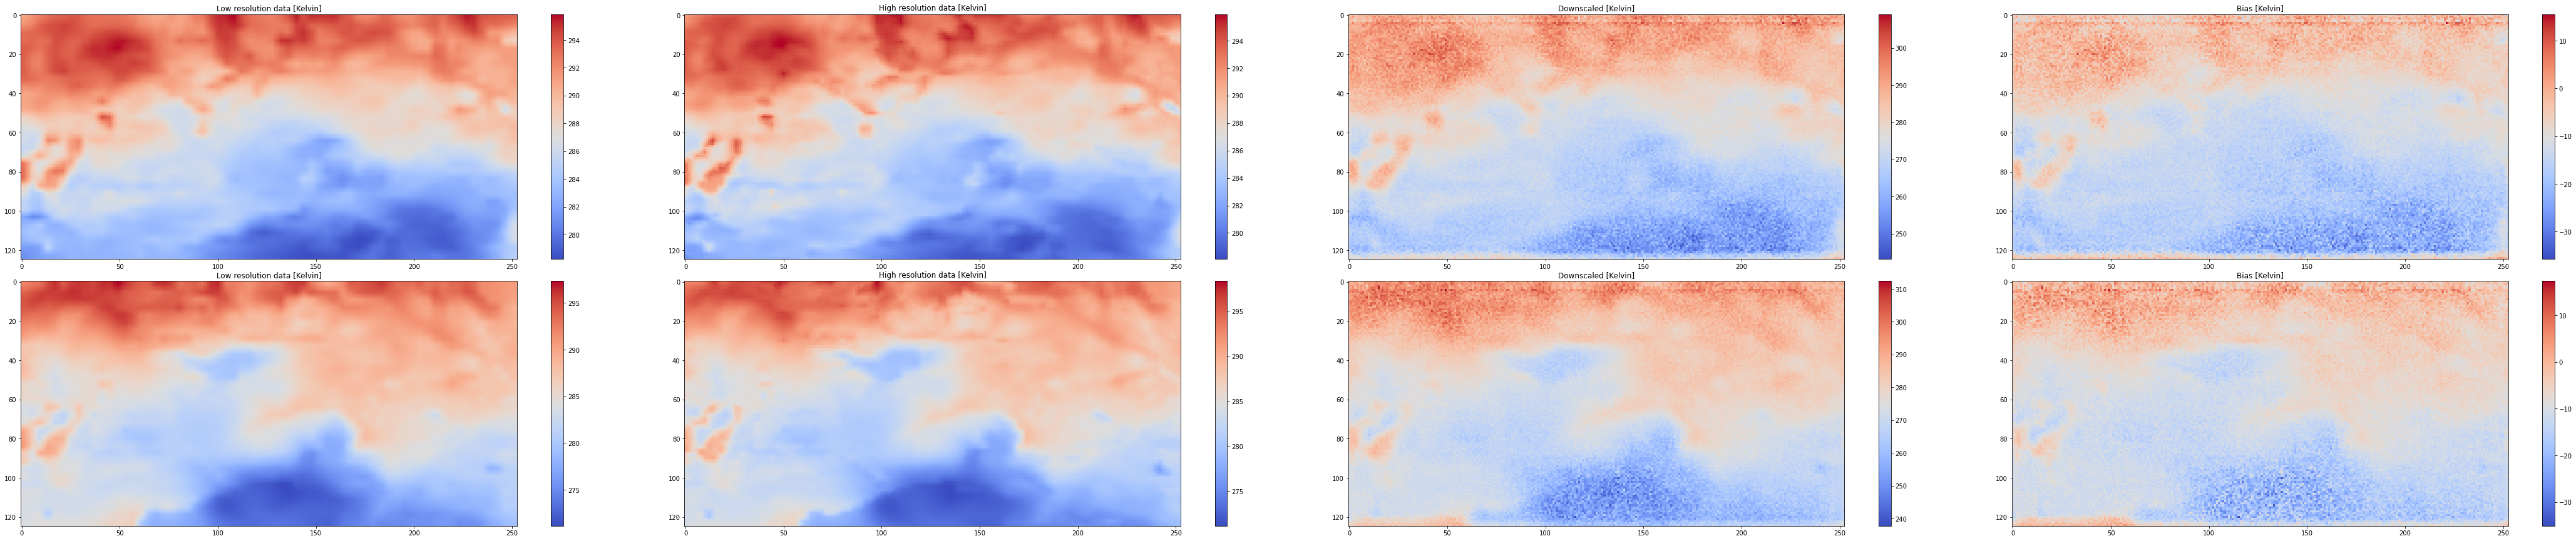

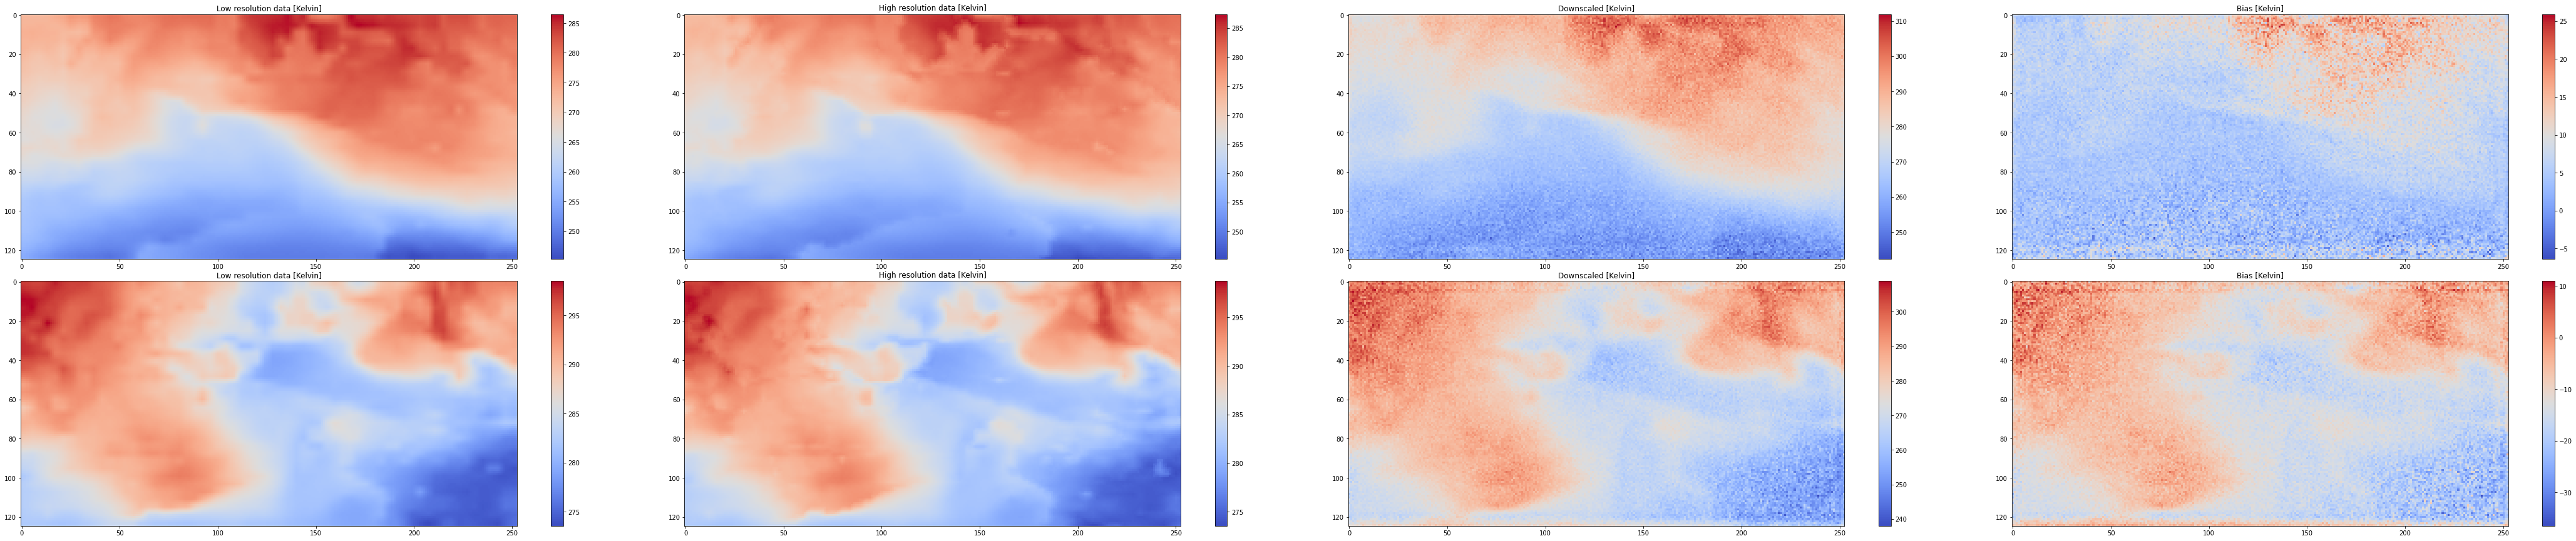

In [ ]:
#Test functions for deployment
from IPython.display import display

test_dates = get_random_dates(data_module)
print("Testing with dates:", test_dates)
test_image = visualize_gradio(test_dates)
display(test_image)